In [23]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import matplotlib.colors as mcolors
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [28]:
class k_color:
    def __init__(self, n, K, elist):
        self.n = n
        self.K = K
        self.G = nx.Graph()
        self.G.add_nodes_from(np.arange(0,n,1))
        self.elist = elist
        # tuple is (i,j,weight) where (i,j) is the edge
        self.G.add_weighted_edges_from(elist)

    def draw(self, color = False):
        if color:
            base_colors = mcolors.BASE_COLORS.keys()
            colors = [np.where(self.solution)[1][node] for node in self.G.nodes()]
        else:
            colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def solve(self):
        # Create an instance of a model and variables
        mdl = Model(name='k-color')
        x = {(i,k): mdl.binary_var(name='x_{0}_{1}'.format(i, k)) for i in range(self.n) for k in range(self.K)}

        # Object function
        knapsack_func = mdl.sum(x[(i,k)] * x[(j,k)] for (i,j,w) in self.elist for k in range(self.K))
        mdl.minimize(knapsack_func)

        # Constrains
        for i in range(self.n):
            mdl.add_constraint(mdl.sum(x[(i,k)] for k in range(self.K)) == 1)
        
        # Get operator
        qubitOp_docplex, offset_docplex = docplex.get_operator(mdl, auto_penalty=False, default_penalty=1e5)
        
        # Solve
        adam = ADAM(maxiter=1000)#optimizer
        qaoa = QAOA(qubitOp_docplex, adam)#QAOA solver

        backend = Aer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend)
        self.result = qaoa.run(quantum_instance)
        self.solution = np.array(common.sample_most_likely(self.result['eigvecs'][0])).reshape([-1,self.K])
        print('solution:', self.solution)

In [29]:
#generate the graph
k_col = k_color(n = 4, K = 4, elist = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(1,3,1.0),(2,3,1.0)])

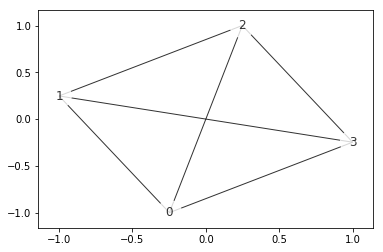

In [30]:
k_col.draw()

In [31]:
k_col.solve()

solution: [[1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 0.]]


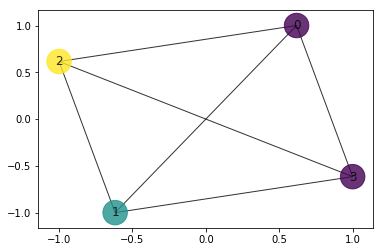

In [32]:
k_col.draw(color = True)